##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Super resolution with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/super_resolution/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Overview

The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model used here is ESRGAN
([ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219)). And we are going to use TensorFlow Lite to run inference on the pretrained model.

The TFLite model is converted from this
[implementation](https://tfhub.dev/captain-pool/esrgan-tf2/1) hosted on TF Hub. Note that the model we converted upsamples a 50x50 low resolution image to a 200x200 high resolution image (scale factor=4). If you want a different input size or scale factor, you need to re-convert or re-train the original model.

## Setup

Let's install required libraries first.

In [2]:
# !pip install matplotlib tensorflow-gpu tensorflow-hub

Import dependencies.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
print(tf.__version__)


2.7.0


Download and convert the ESRGAN model

In [60]:
# dir(converter)
dir(concrete_func)
# concrete_func.output_shapes
# concrete_func.variables

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arg_keywords',
 '_as_name_attr_list',
 '_attrs',
 '_build_call_outputs',
 '_call_flat',
 '_call_impl',
 '_call_with_flat_signature',
 '_call_with_structured_signature',
 '_captured_inputs',
 '_delayed_rewrite_functions',
 '_experimental_with_cancellation_manager',
 '_first_order_tape_functions',
 '_flat_signature_summary',
 '_func_graph',
 '_function_spec',
 '_garbage_collector',
 '_get_gradient_function',
 '_higher_order_tape_functions',
 '_inference_function',
 '_initialize_function_spec',
 '_num_positional_args',
 '_output_shapes',
 '_pre_initialized_function_spec',
 '_select_forward_and_backward_functio

In [61]:
concrete_func.output_shapes=tf.TensorShape([1, 111, 111, 3]

{'rrdb_net': TensorShape([None, None, None, 3])}

In [63]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")


concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 50, 50, 3])
concrete_func.outputs[0].set_shape([1, 150, 150, 3])
concrete_func.output_shapes=tf.TensorShape([1, 150, 150, 3])
converter.allow_custom_ops=True
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

AttributeError: can't set attribute

Download a test image (insect head).

In [27]:
!ls {test_img_path}

/prj/nowage/ImgAugWithSR/lr-1.jpg


In [28]:
# test_img_path = tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')
# test_img_path = tf.keras.utils.get_file('lr.jpg', 'http://j.finfra.com/_file/messi5.jpg')
#test_img_path="/content/a2.jpg"
# test_img_path="/content/a.jpg"
#test_img_path = tf.keras.utils.get_file('lr.jpg', 'http://finfra.com/f/f.png')
#test_img_path="/prj/nowage/a1.jpg"
# !pwd
# !wget https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg
test_img_path="/prj/nowage/ImgAugWithSR/lr-1.jpg"

In [29]:
# test_img_path="/prj/nowage/ImgAugWithSR/a4.jpg"

## Generate a super resolution image using TensorFlow Lite

In [64]:
lr = tf.io.read_file(test_img_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()

output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

In [32]:
input_details

[{'name': 'input_0',
  'index': 0,
  'shape': array([ 1, 50, 50,  3], dtype=int32),
  'shape_signature': array([ 1, 50, 50,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [65]:
output_details

[{'name': 'Identity',
  'index': 840,
  'shape': array([  1, 200, 200,   3], dtype=int32),
  'shape_signature': array([  1, 200, 200,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## Visualize the result

In [12]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [100, 100], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 50 [Op:Squeeze]

## Performance Benchmarks

Performance benchmark numbers are generated with the tool
[described here](https://www.tensorflow.org/lite/performance/benchmarks).

<table>
  <thead>
    <tr>
      <th>Model Name</th>
      <th>Model Size </th>
      <th>Device </th>
      <th>CPU</th>
      <th>GPU</th>
    </tr>
  </thead>
  <tr>
    <td rowspan = 3>
      super resolution (ESRGAN)
    </td>
    <td rowspan = 3>
      4.8 Mb
    </td>
    <td>Pixel 3</td>
    <td>586.8ms*</td>
      <td>128.6ms</td>
  </tr>
  <tr>
     <td>Pixel 4</td>
    <td>385.1ms*</td>
      <td>130.3ms</td>
  </tr>

</table>

**4 threads used*

In [34]:
test_img_path="/prj/nowage/ImgAugWithSR/a3.jpg"
lr = tf.io.read_file(test_img_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)


In [35]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]


concrete_func.inputs[0].set_shape(lr.shape.as_list())
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)

interpreter.allocate_tensors()



# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

2021-11-10 13:17:08.805015: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2021-11-10 13:17:08.805091: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2021-11-10 13:17:08.807112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5306 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
2021-11-10 13:17:08.807385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5380 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1
2021-11-10 13:17:08.864018: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 1953 nodes (1608), 3017 edges 

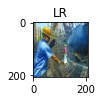

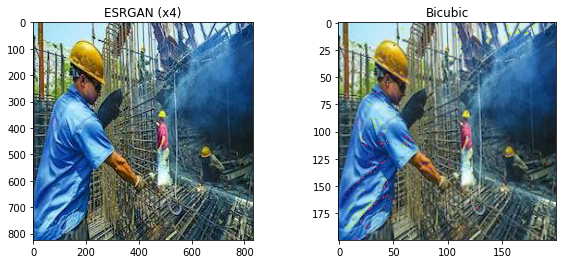

In [36]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

In [39]:
img=lr.numpy()
plt.imsave('/prj/nowage/ImgAugWithSR/a4x.jpg',img)

In [44]:
import os
path_dir = '/prj/nowage/ImgAugWithSR/imgs/HardHatSample__all/images'
file_list = os.listdir(path_dir)


In [46]:
!ls /prj/nowage/ImgAugWithSR/imgs/HardHatSample__all/images

000001_jpg.rf.45fd629cae669b7236f4f5484605be64.jpg
000002_jpg.rf.14c099486ff0a2df2d20d82da93b46f5.jpg
000003_jpg.rf.da4ac3b48b7a600add2281eacaf7dd82.jpg
000004_jpg.rf.8f0984ca266ad0bb1ccce4a3dc095291.jpg
000005_jpg.rf.b5cf39466979e5caca32c370a42c10a1.jpg
000006_jpg.rf.bb8c1e53f96b504e903ed949ab36d897.jpg
000007_jpg.rf.7e374970640ea260a4a7d08f3800911e.jpg
000008_jpg.rf.2db0739ce167e12a1c2a3a46037cf392.jpg
000009_jpg.rf.4cced240a4a0ee03faa5618bd2d37057.jpg
000010_jpg.rf.0a931332a562680b7479eab60a06f51a.jpg
000011_jpg.rf.bb80027990ed628288961d26c61b9a1f.jpg
000012_jpg.rf.d364720c049aa4dd0ab0b3bc438e25bf.jpg
000013_jpg.rf.7565864e3474c95ccf2a05508b5125a8.jpg
000014_jpg.rf.98a4e9216735031416eec1723092bead.jpg
000015_jpg.rf.19833f23150a0223066ef396bb419e9a.jpg
000016_jpg.rf.6e69067f00df713bd509c997286b2ae8.jpg
000017_jpg.rf.7f8687553bd06c072b75febd66341a64.jpg
000018_jpg.rf.9342c0bd4e259b60935dd3cf9e7d99ac.jpg
000019_jpg.rf.9ba3d416ec138f4d756e3b8c15d53fdc.jpg
000020_jpg.rf.0589037e18faf16b7